In [3]:
# ops.py
from __future__ import division
import tensorflow as tf


# model.py
import numpy as np
#import tensorflow as tf
# from .ops import causal_conv, mu_law_encode


# train.py
"""Training script for the WaveNet network on the VCTK corpus.
This script trains a network with the WaveNet using data from the VCTK corpus,
which can be freely downloaded at the following site (~10 GB):
http://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html
"""
from __future__ import print_function
import argparse
from datetime import datetime
import json
import os
import sys
import time

#import tensorflow as tf
from tensorflow.python.client import timeline

# from wavenet import WaveNetModel, AudioReader, optimizer_factory

In [12]:
wavenet_params = {
    "filter_width": 2,
    "sample_rate": 22050,
    "dilations": [1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512,
                  1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
    "residual_channels": 16,
    "dilation_channels": 16,
    "quantization_channels": 256,
    "skip_channels": 16,
    "use_biases": True,
    "scalar_input": False,
    "initial_filter_width": 32
}

In [4]:
def create_adam_optimizer(learning_rate, momentum):
    return tf.train.AdamOptimizer(learning_rate=learning_rate,
                                  epsilon=1e-4)


def create_sgd_optimizer(learning_rate, momentum):
    return tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                      momentum=momentum)


def create_rmsprop_optimizer(learning_rate, momentum):
    return tf.train.RMSPropOptimizer(learning_rate=learning_rate,
                                     momentum=momentum,
                                     epsilon=1e-5)


optimizer_factory = {'adam': create_adam_optimizer,
                     'sgd': create_sgd_optimizer,
                     'rmsprop': create_rmsprop_optimizer}

In [5]:
def time_to_batch(value, dilation, name=None):
    with tf.name_scope('time_to_batch'):
        shape = tf.shape(value)
        pad_elements = dilation - 1 - (shape[1] + dilation - 1) % dilation
        padded = tf.pad(value, [[0, 0], [0, pad_elements], [0, 0]])
        reshaped = tf.reshape(padded, [-1, dilation, shape[2]])
        transposed = tf.transpose(reshaped, perm=[1, 0, 2])
        return tf.reshape(transposed, [shape[0] * dilation, -1, shape[2]])


def batch_to_time(value, dilation, name=None):
    with tf.name_scope('batch_to_time'):
        shape = tf.shape(value)
        prepared = tf.reshape(value, [dilation, -1, shape[2]])
        transposed = tf.transpose(prepared, perm=[1, 0, 2])
        return tf.reshape(transposed,
                          [tf.div(shape[0], dilation), -1, shape[2]])


def causal_conv(value, filter_, dilation, name='causal_conv'):
    with tf.name_scope(name):
        filter_width = tf.shape(filter_)[0]
        if dilation > 1:
            transformed = time_to_batch(value, dilation)
            conv = tf.nn.conv1d(transformed, filter_, stride=1,
                                padding='VALID')
            restored = batch_to_time(conv, dilation)
        else:
            restored = tf.nn.conv1d(value, filter_, stride=1, padding='VALID')
        # Remove excess elements at the end.
        out_width = tf.shape(value)[1] - (filter_width - 1) * dilation
        result = tf.slice(restored,
                          [0, 0, 0],
                          [-1, out_width, -1])
        return result

In [6]:
def mu_law_encode(audio, quantization_channels):
    '''Quantizes waveform amplitudes.'''
    with tf.name_scope('encode'):
        mu = tf.to_float(quantization_channels - 1)
        # Perform mu-law companding transformation (ITU-T, 1988).
        # Minimum operation is here to deal with rare large amplitudes caused
        # by resampling.
        safe_audio_abs = tf.minimum(tf.abs(audio), 1.0)
        magnitude = tf.log1p(mu * safe_audio_abs) / tf.log1p(mu)
        signal = tf.sign(audio) * magnitude
        # Quantize signal to the specified number of levels.
        return tf.to_int32((signal + 1) / 2 * mu + 0.5)


def mu_law_decode(output, quantization_channels):
    '''Recovers waveform from quantized values.'''
    with tf.name_scope('decode'):
        mu = quantization_channels - 1
        # Map values back to [-1, 1].
        signal = 2 * (tf.to_float(output) / mu) - 1
        # Perform inverse of mu-law transformation.
        magnitude = (1 / mu) * ((1 + mu)**abs(signal) - 1)
        return tf.sign(signal) * magnitude

In [7]:
# model.py


def create_variable(name, shape):
    '''Create a convolution filter variable with the specified name and shape,
    and initialize it using Xavier initialition.'''
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
    variable = tf.Variable(initializer(shape=shape), name=name)
    return variable


def create_embedding_table(name, shape):
    if shape[0] == shape[1]:
        # Make a one-hot encoding as the initial value.
        initial_val = np.identity(n=shape[0], dtype=np.float32)
        return tf.Variable(initial_val, name=name)
    else:
        return create_variable(name, shape)


def create_bias_variable(name, shape):
    '''Create a bias variable with the specified name and shape and initialize
    it to zero.'''
    initializer = tf.constant_initializer(value=0.0, dtype=tf.float32)
    return tf.Variable(initializer(shape=shape), name)

In [8]:
class WaveNetModel(object):
    '''Implements the WaveNet network for generative audio.

    Usage (with the architecture as in the DeepMind paper):
        dilations = [2**i for i in range(N)] * M
        filter_width = 2  # Convolutions just use 2 samples.
        residual_channels = 16  # Not specified in the paper.
        dilation_channels = 32  # Not specified in the paper.
        skip_channels = 16      # Not specified in the paper.
        net = WaveNetModel(batch_size, dilations, filter_width,
                           residual_channels, dilation_channels,
                           skip_channels)
        loss = net.loss(input_batch)
    '''

    def __init__(self,
                 batch_size,
                 dilations,
                 filter_width,
                 residual_channels,
                 dilation_channels,
                 skip_channels,
                 quantization_channels=2**8,
                 use_biases=False,
                 scalar_input=False,
                 initial_filter_width=32,
                 histograms=False):
        '''Initializes the WaveNet model.

        Args:
            batch_size: How many audio files are supplied per batch
                (recommended: 1).
            dilations: A list with the dilation factor for each layer.
            filter_width: The samples that are included in each convolution,
                after dilating.
            residual_channels: How many filters to learn for the residual.
            dilation_channels: How many filters to learn for the dilated
                convolution.
            skip_channels: How many filters to learn that contribute to the
                quantized softmax output.
            quantization_channels: How many amplitude values to use for audio
                quantization and the corresponding one-hot encoding.
                Default: 256 (8-bit quantization).
            use_biases: Whether to add a bias layer to each convolution.
                Default: False.
            scalar_input: Whether to use the quantized waveform directly as
                input to the network instead of one-hot encoding it.
                Default: False.
            initial_filter_width: The width of the initial filter of the
                convolution applied to the scalar input. This is only relevant
                if scalar_input=True.
            histograms: Whether to store histograms in the summary.
                Default: False.


        '''
        self.batch_size = batch_size
        self.dilations = dilations
        self.filter_width = filter_width
        self.residual_channels = residual_channels
        self.dilation_channels = dilation_channels
        self.quantization_channels = quantization_channels
        self.use_biases = use_biases
        self.skip_channels = skip_channels
        self.scalar_input = scalar_input
        self.initial_filter_width = initial_filter_width
        self.histograms = histograms

        self.receptive_field = WaveNetModel.calculate_receptive_field(
            self.filter_width, self.dilations, self.scalar_input,
            self.initial_filter_width)
        self.variables = self._create_variables()

    @staticmethod
    def calculate_receptive_field(filter_width, dilations, scalar_input,
                                  initial_filter_width):
        receptive_field = (filter_width - 1) * sum(dilations) + 1
        if scalar_input:
            receptive_field += initial_filter_width - 1
        else:
            receptive_field += filter_width - 1
        return receptive_field

    def _create_variables(self):
        '''This function creates all variables used by the network.
        This allows us to share them between multiple calls to the loss
        function and generation function.'''

        var = dict()

        with tf.variable_scope('wavenet'):
            with tf.variable_scope('causal_layer'):
                layer = dict()
                if self.scalar_input:
                    initial_channels = 1
                    initial_filter_width = self.initial_filter_width
                else:
                    initial_channels = self.quantization_channels
                    initial_filter_width = self.filter_width
                layer['filter'] = create_variable(
                    'filter',
                    [initial_filter_width,
                     initial_channels,
                     self.residual_channels])
                var['causal_layer'] = layer

            var['dilated_stack'] = list()
            with tf.variable_scope('dilated_stack'):
                for i, dilation in enumerate(self.dilations):
                    with tf.variable_scope('layer{}'.format(i)):
                        current = dict()
                        current['filter'] = create_variable(
                            'filter',
                            [self.filter_width,
                             self.residual_channels,
                             self.dilation_channels])
                        current['gate'] = create_variable(
                            'gate',
                            [self.filter_width,
                             self.residual_channels,
                             self.dilation_channels])
                        current['dense'] = create_variable(
                            'dense',
                            [1,
                             self.dilation_channels,
                             self.residual_channels])
                        current['skip'] = create_variable(
                            'skip',
                            [1,
                             self.dilation_channels,
                             self.skip_channels])



                        if self.use_biases:
                            current['filter_bias'] = create_bias_variable(
                                'filter_bias',
                                [self.dilation_channels])
                            current['gate_bias'] = create_bias_variable(
                                'gate_bias',
                                [self.dilation_channels])
                            current['dense_bias'] = create_bias_variable(
                                'dense_bias',
                                [self.residual_channels])
                            current['skip_bias'] = create_bias_variable(
                                'slip_bias',
                                [self.skip_channels])

                        var['dilated_stack'].append(current)

            with tf.variable_scope('postprocessing'):
                current = dict()
                current['postprocess1'] = create_variable(
                    'postprocess1',
                    [1, self.skip_channels, self.skip_channels])
                current['postprocess2'] = create_variable(
                    'postprocess2',
                    [1, self.skip_channels, 1])
                if self.use_biases:
                    current['postprocess1_bias'] = create_bias_variable(
                        'postprocess1_bias',
                        [self.skip_channels])
                    current['postprocess2_bias'] = create_bias_variable(
                        'postprocess2_bias',
                        [1])
                var['postprocessing'] = current

        return var

    def _create_causal_layer(self, input_batch):
        '''Creates a single causal convolution layer.

        The layer can change the number of channels.
        '''
        with tf.name_scope('causal_layer'):
            weights_filter = self.variables['causal_layer']['filter']
            return causal_conv(input_batch, weights_filter, 1)

    def _create_dilation_layer(self, input_batch, layer_index, dilation,
                               output_width):
        '''Creates a single causal dilated convolution layer.

        Args:
             input_batch: Input to the dilation layer.
             layer_index: Integer indicating which layer this is.
             dilation: Integer specifying the dilation size.

        The layer contains a gated filter that connects to dense output
        and to a skip connection:

               |-> [gate]   -|        |-> 1x1 conv -> skip output
               |             |-> (*) -|
        input -|-> [filter] -|        |-> 1x1 conv -|
               |                                    |-> (+) -> dense output
               |------------------------------------|

        Where `[gate]` and `[filter]` are causal convolutions with a
        non-linear activation at the output. Biases and global conditioning
        are omitted due to the limits of ASCII art.

        '''
        variables = self.variables['dilated_stack'][layer_index]

        weights_filter = variables['filter']
        weights_gate = variables['gate']

        conv_filter = causal_conv(input_batch, weights_filter, dilation)
        conv_gate = causal_conv(input_batch, weights_gate, dilation)


        if self.use_biases:
            filter_bias = variables['filter_bias']
            gate_bias = variables['gate_bias']
            conv_filter = tf.add(conv_filter, filter_bias)
            conv_gate = tf.add(conv_gate, gate_bias)

        out = tf.tanh(conv_filter) * tf.sigmoid(conv_gate)

        # The 1x1 conv to produce the residual output
        weights_dense = variables['dense']
        transformed = tf.nn.conv1d(
            out, weights_dense, stride=1, padding="SAME", name="dense")

        # The 1x1 conv to produce the skip output
        skip_cut = tf.shape(out)[1] - output_width
        out_skip = tf.slice(out, [0, skip_cut, 0], [-1, -1, -1])
        weights_skip = variables['skip']
        skip_contribution = tf.nn.conv1d(
            out_skip, weights_skip, stride=1, padding="SAME", name="skip")

        if self.use_biases:
            dense_bias = variables['dense_bias']
            skip_bias = variables['skip_bias']
            transformed = transformed + dense_bias
            skip_contribution = skip_contribution + skip_bias

        if self.histograms:
            layer = 'layer{}'.format(layer_index)
            tf.histogram_summary(layer + '_filter', weights_filter)
            tf.histogram_summary(layer + '_gate', weights_gate)
            tf.histogram_summary(layer + '_dense', weights_dense)
            tf.histogram_summary(layer + '_skip', weights_skip)
            if self.use_biases:
                tf.histogram_summary(layer + '_biases_filter', filter_bias)
                tf.histogram_summary(layer + '_biases_gate', gate_bias)
                tf.histogram_summary(layer + '_biases_dense', dense_bias)
                tf.histogram_summary(layer + '_biases_skip', skip_bias)

        input_cut = tf.shape(input_batch)[1] - tf.shape(transformed)[1]
        input_batch = tf.slice(input_batch, [0, input_cut, 0], [-1, -1, -1])

        return skip_contribution, input_batch + transformed

    def _generator_conv(self, input_batch, state_batch, weights):
        '''Perform convolution for a single convolutional processing step.'''
        # TODO generalize to filter_width > 2
        past_weights = weights[0, :, :]
        curr_weights = weights[1, :, :]
        output = tf.matmul(state_batch, past_weights) + tf.matmul(
            input_batch, curr_weights)
        return output

    def _generator_causal_layer(self, input_batch, state_batch):
        with tf.name_scope('causal_layer'):
            weights_filter = self.variables['causal_layer']['filter']
            output = self._generator_conv(
                input_batch, state_batch, weights_filter)
        return output

    def _generator_dilation_layer(self, input_batch, state_batch, layer_index,
                                  dilation):
        variables = self.variables['dilated_stack'][layer_index]

        weights_filter = variables['filter']
        weights_gate = variables['gate']
        output_filter = self._generator_conv(
            input_batch, state_batch, weights_filter)
        output_gate = self._generator_conv(
            input_batch, state_batch, weights_gate)

        if self.use_biases:
            output_filter = output_filter + variables['filter_bias']
            output_gate = output_gate + variables['gate_bias']

        out = tf.tanh(output_filter) * tf.sigmoid(output_gate)

        weights_dense = variables['dense']
        transformed = tf.matmul(out, weights_dense[0, :, :])
        if self.use_biases:
            transformed = transformed + variables['dense_bias']

        weights_skip = variables['skip']
        skip_contribution = tf.matmul(out, weights_skip[0, :, :])
        if self.use_biases:
            skip_contribution = skip_contribution + variables['skip_bias']

        return skip_contribution, input_batch + transformed

    def _create_network(self, input_batch):
        '''Construct the WaveNet network.'''
        outputs = []
        current_layer = input_batch

        # Pre-process the input with a regular convolution
        if self.scalar_input:
            initial_channels = 1
        else:
            initial_channels = self.quantization_channels

        current_layer = self._create_causal_layer(current_layer)

        output_width = tf.shape(input_batch)[1] - self.receptive_field + 1

        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):
                    output, current_layer = self._create_dilation_layer(
                        current_layer, layer_index, dilation,
                        output_width)
                    outputs.append(output)

        with tf.name_scope('postprocessing'):
            # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
            # postprocess the output.
            w1 = self.variables['postprocessing']['postprocess1']
            w2 = self.variables['postprocessing']['postprocess2']
            if self.use_biases:
                b1 = self.variables['postprocessing']['postprocess1_bias']
                b2 = self.variables['postprocessing']['postprocess2_bias']

            if self.histograms:
                tf.histogram_summary('postprocess1_weights', w1)
                tf.histogram_summary('postprocess2_weights', w2)
                if self.use_biases:
                    tf.histogram_summary('postprocess1_biases', b1)
                    tf.histogram_summary('postprocess2_biases', b2)

            # We skip connections from the outputs of each layer, adding them
            # all up here.
            total = sum(outputs)
            transformed1 = tf.nn.relu(total)
            conv1 = tf.nn.conv1d(transformed1, w1, stride=1, padding="SAME")
            if self.use_biases:
                conv1 = tf.add(conv1, b1)
            transformed2 = tf.nn.relu(conv1)
            conv2 = tf.nn.conv1d(transformed2, w2, stride=1, padding="SAME")
            if self.use_biases:
                conv2 = tf.add(conv2, b2)

        return conv2

    def _create_generator(self, input_batch):
        '''Construct an efficient incremental generator.'''
        init_ops = []
        push_ops = []
        outputs = []
        current_layer = input_batch

        q = tf.FIFOQueue(
            1,
            dtypes=tf.float32,
            shapes=(self.batch_size, self.quantization_channels))
        init = q.enqueue_many(
            tf.zeros((1, self.batch_size, self.quantization_channels)))

        current_state = q.dequeue()
        push = q.enqueue([current_layer])
        init_ops.append(init)
        push_ops.append(push)

        current_layer = self._generator_causal_layer(
                            current_layer, current_state)

        # Add all defined dilation layers.
        with tf.name_scope('dilated_stack'):
            for layer_index, dilation in enumerate(self.dilations):
                with tf.name_scope('layer{}'.format(layer_index)):

                    q = tf.FIFOQueue(
                        dilation,
                        dtypes=tf.float32,
                        shapes=(self.batch_size, self.residual_channels))
                    init = q.enqueue_many(
                        tf.zeros((dilation, self.batch_size,
                                  self.residual_channels)))

                    current_state = q.dequeue()
                    push = q.enqueue([current_layer])
                    init_ops.append(init)
                    push_ops.append(push)

                    output, current_layer = self._generator_dilation_layer(
                        current_layer, current_state, layer_index, dilation)
                    outputs.append(output)
        self.init_ops = init_ops
        self.push_ops = push_ops

        with tf.name_scope('postprocessing'):
            variables = self.variables['postprocessing']
            # Perform (+) -> ReLU -> 1x1 conv -> ReLU -> 1x1 conv to
            # postprocess the output.
            w1 = variables['postprocess1']
            w2 = variables['postprocess2']
            if self.use_biases:
                b1 = variables['postprocess1_bias']
                b2 = variables['postprocess2_bias']

            # We skip connections from the outputs of each layer, adding them
            # all up here.
            total = sum(outputs)
            transformed1 = tf.nn.relu(total)

            conv1 = tf.matmul(transformed1, w1[0, :, :])
            if self.use_biases:
                conv1 = conv1 + b1
            transformed2 = tf.nn.relu(conv1)
            conv2 = tf.matmul(transformed2, w2[0, :, :])
            if self.use_biases:
                conv2 = conv2 + b2

        return conv2

    def _one_hot(self, input_batch):
        '''One-hot encodes the waveform amplitudes.

        This allows the definition of the network as a categorical distribution
        over a finite set of possible amplitudes.
        '''
        with tf.name_scope('one_hot_encode'):
            encoded = tf.one_hot(
                input_batch,
                depth=self.quantization_channels,
                dtype=tf.float32)
            shape = [self.batch_size, -1, self.quantization_channels]
            encoded = tf.reshape(encoded, shape)
        return encoded

    def predict_proba(self, waveform, name='wavenet'):
        '''Computes the probability distribution of the next sample based on
        all samples in the input waveform.
        If you want to generate audio by feeding the output of the network back
        as an input, see predict_proba_incremental for a faster alternative.'''
        with tf.name_scope(name):
            if self.scalar_input:
                encoded = tf.cast(waveform, tf.float32)
                encoded = tf.reshape(encoded, [-1, 1])
            else:
                encoded = self._one_hot(waveform)

            raw_output = self._create_network(encoded)
            out = tf.reshape(raw_output, [-1, self.quantization_channels])
            # Cast to float64 to avoid bug in TensorFlow
            proba = tf.cast(
                tf.nn.softmax(tf.cast(out, tf.float64)), tf.float32)
            last = tf.slice(
                proba,
                [tf.shape(proba)[0] - 1, 0],
                [1, self.quantization_channels])
            return tf.reshape(last, [-1])

    def predict_proba_incremental(self, waveform,
                                  name='wavenet'):
        '''Computes the probability distribution of the next sample
        incrementally, based on a single sample and all previously passed
        samples.'''
        if self.filter_width > 2:
            raise NotImplementedError("Incremental generation does not "
                                      "support filter_width > 2.")
        if self.scalar_input:
            raise NotImplementedError("Incremental generation does not "
                                      "support scalar input yet.")
        with tf.name_scope(name):
            encoded = tf.one_hot(waveform, self.quantization_channels)
            encoded = tf.reshape(encoded, [-1, self.quantization_channels])
            raw_output = self._create_generator(encoded)
            out = tf.reshape(raw_output, [-1, self.quantization_channels])
            proba = tf.cast(
                tf.nn.softmax(tf.cast(out, tf.float64)), tf.float32)
            last = tf.slice(
                proba,
                [tf.shape(proba)[0] - 1, 0],
                [1, self.quantization_channels])
            return tf.reshape(last, [-1])

    def loss(self,
             input_batch,
             l2_regularization_strength=None,
             name='wavenet'):
        '''Creates a WaveNet network and returns the autoencoding loss.

        The variables are all scoped to the given name.
        '''
        with tf.name_scope(name):
            # We mu-law encode and quantize the input audioform.
            encoded_input = mu_law_encode(input_batch,
                                          self.quantization_channels)

            encoded = self._one_hot(encoded_input)
            if self.scalar_input:
                network_input = tf.reshape(
                    tf.cast(input_batch, tf.float32),
                    [self.batch_size, -1, 1])
            else:
                network_input = encoded

            # Cut off the last sample of network input to preserve causality.
            network_input_width = tf.shape(network_input)[1] - 1
            network_input = tf.slice(network_input, [0, 0, 0],
                                     [-1, network_input_width, -1])

            raw_output = self._create_network(network_input)

            with tf.name_scope('loss'):
                # Cut off the samples corresponding to the receptive field
                # for the first predicted sample.
                target_output = tf.slice(
                    tf.reshape(
                        encoded,
                        [self.batch_size, -1, self.quantization_channels]),
                    [0, self.receptive_field, 0],
                    [-1, -1, -1])
                target_output = tf.reshape(target_output,
                                           [-1, self.quantization_channels])
                prediction = tf.reshape(raw_output,
                                        [-1, self.quantization_channels])
                loss = tf.nn.softmax_cross_entropy_with_logits(
                    logits=prediction,
                    labels=target_output)
                reduced_loss = tf.reduce_mean(loss)

                tf.summary.scalar('loss', reduced_loss)

                if l2_regularization_strength is None:
                    return reduced_loss
                else:
                    # L2 regularization for all trainable parameters
                    l2_loss = tf.add_n([tf.nn.l2_loss(v)
                                        for v in tf.trainable_variables()
                                        if not('bias' in v.name)])

                    # Add the regularization term to the loss
                    total_loss = (reduced_loss +
                                  l2_regularization_strength * l2_loss)

                    tf.summary.scalar('l2_loss', l2_loss)
                    tf.summary.scalar('total_loss', total_loss)

                    return total_loss

In [9]:
# train.py



BATCH_SIZE = 1
DATA_DIRECTORY = './VCTK-Corpus'
LOGDIR_ROOT = './logdir'
CHECKPOINT_EVERY = 50
NUM_STEPS = int(1e5)
LEARNING_RATE = 1e-3
WAVENET_PARAMS = './wavenet_params.json'
STARTED_DATESTRING = "{0:%Y-%m-%dT%H-%M-%S}".format(datetime.now())
SAMPLE_SIZE = 100000
L2_REGULARIZATION_STRENGTH = 0
SILENCE_THRESHOLD = 0.3
EPSILON = 0.001
MOMENTUM = 0.9
MAX_TO_KEEP = 5
METADATA = False


def get_arguments():
    def _str_to_bool(s):
        """Convert string to bool (in argparse context)."""
        if s.lower() not in ['true', 'false']:
            raise ValueError('Argument needs to be a '
                             'boolean, got {}'.format(s))
        return {'true': True, 'false': False}[s.lower()]

    parser = argparse.ArgumentParser(description='WaveNet example network')
    parser.add_argument('--batch_size', type=int, default=BATCH_SIZE,
                        help='How many wav files to process at once. Default: ' + str(BATCH_SIZE) + '.')
    parser.add_argument('--data_dir', type=str, default=DATA_DIRECTORY,
                        help='The directory containing the VCTK corpus.')
    parser.add_argument('--store_metadata', type=bool, default=METADATA,
                        help='Whether to store advanced debugging information '
                        '(execution time, memory consumption) for use with '
                        'TensorBoard. Default: ' + str(METADATA) + '.')
    parser.add_argument('--logdir', type=str, default=None,
                        help='Directory in which to store the logging '
                        'information for TensorBoard. '
                        'If the model already exists, it will restore '
                        'the state and will continue training. '
                        'Cannot use with --logdir_root and --restore_from.')
    parser.add_argument('--logdir_root', type=str, default=None,
                        help='Root directory to place the logging '
                        'output and generated model. These are stored '
                        'under the dated subdirectory of --logdir_root. '
                        'Cannot use with --logdir.')
    parser.add_argument('--restore_from', type=str, default=None,
                        help='Directory in which to restore the model from. '
                        'This creates the new model under the dated directory '
                        'in --logdir_root. '
                        'Cannot use with --logdir.')
    parser.add_argument('--checkpoint_every', type=int,
                        default=CHECKPOINT_EVERY,
                        help='How many steps to save each checkpoint after. Default: ' + str(CHECKPOINT_EVERY) + '.')
    parser.add_argument('--num_steps', type=int, default=NUM_STEPS,
                        help='Number of training steps. Default: ' + str(NUM_STEPS) + '.')
    parser.add_argument('--learning_rate', type=float, default=LEARNING_RATE,
                        help='Learning rate for training. Default: ' + str(LEARNING_RATE) + '.')
    parser.add_argument('--wavenet_params', type=str, default=WAVENET_PARAMS,
                        help='JSON file with the network parameters. Default: ' + WAVENET_PARAMS + '.')
    parser.add_argument('--sample_size', type=int, default=SAMPLE_SIZE,
                        help='Concatenate and cut audio samples to this many '
                        'samples. Default: ' + str(SAMPLE_SIZE) + '.')
    parser.add_argument('--l2_regularization_strength', type=float,
                        default=L2_REGULARIZATION_STRENGTH,
                        help='Coefficient in the L2 regularization. '
                        'Default: False')
    parser.add_argument('--silence_threshold', type=float,
                        default=SILENCE_THRESHOLD,
                        help='Volume threshold below which to trim the start '
                        'and the end from the training set samples. Default: ' + str(SILENCE_THRESHOLD) + '.')
    parser.add_argument('--optimizer', type=str, default='adam',
                        choices=optimizer_factory.keys(),
                        help='Select the optimizer specified by this option. Default: adam.')
    parser.add_argument('--momentum', type=float,
                        default=MOMENTUM, help='Specify the momentum to be '
                        'used by sgd or rmsprop optimizer. Ignored by the '
                        'adam optimizer. Default: ' + str(MOMENTUM) + '.')
    parser.add_argument('--histograms', type=_str_to_bool, default=False,
                        help='Whether to store histogram summaries. Default: False')
    parser.add_argument('--max_checkpoints', type=int, default=MAX_TO_KEEP,
                        help='Maximum amount of checkpoints that will be kept alive. Default: '
                             + str(MAX_TO_KEEP) + '.')
    return parser.parse_args()


def save(saver, sess, logdir, step):
    model_name = 'model.ckpt'
    checkpoint_path = os.path.join(logdir, model_name)
    print('Storing checkpoint to {} ...'.format(logdir), end="")
    sys.stdout.flush()

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    saver.save(sess, checkpoint_path, global_step=step)
    print(' Done.')


def load(saver, sess, logdir):
    print("Trying to restore saved checkpoints from {} ...".format(logdir),
          end="")

    ckpt = tf.train.get_checkpoint_state(logdir)
    if ckpt:
        print("  Checkpoint found: {}".format(ckpt.model_checkpoint_path))
        global_step = int(ckpt.model_checkpoint_path
                          .split('/')[-1]
                          .split('-')[-1])
        print("  Global step was: {}".format(global_step))
        print("  Restoring...", end="")
        saver.restore(sess, ckpt.model_checkpoint_path)
        print(" Done.")
        return global_step
    else:
        print(" No checkpoint found.")
        return None


def get_default_logdir(logdir_root):
    logdir = os.path.join(logdir_root, 'train', STARTED_DATESTRING)
    return logdir


def validate_directories(args):
    """Validate and arrange directory related arguments."""

    # Validation
    if args.logdir and args.logdir_root:
        raise ValueError("--logdir and --logdir_root cannot be "
                         "specified at the same time.")

    if args.logdir and args.restore_from:
        raise ValueError(
            "--logdir and --restore_from cannot be specified at the same "
            "time. This is to keep your previous model from unexpected "
            "overwrites.\n"
            "Use --logdir_root to specify the root of the directory which "
            "will be automatically created with current date and time, or use "
            "only --logdir to just continue the training from the last "
            "checkpoint.")

    # Arrangement
    logdir_root = args.logdir_root
    if logdir_root is None:
        logdir_root = LOGDIR_ROOT

    logdir = args.logdir
    if logdir is None:
        logdir = get_default_logdir(logdir_root)
        print('Using default logdir: {}'.format(logdir))

    restore_from = args.restore_from
    if restore_from is None:
        # args.logdir and args.restore_from are exclusive,
        # so it is guaranteed the logdir here is newly created.
        restore_from = logdir

    return {
        'logdir': logdir,
        'logdir_root': args.logdir_root,
        'restore_from': restore_from
    }


def main():
    args = get_arguments()

    try:
        directories = validate_directories(args)
    except ValueError as e:
        print("Some arguments are wrong:")
        print(str(e))
        return

    logdir = directories['logdir']
    restore_from = directories['restore_from']

    # Even if we restored the model, we will treat it as new training
    # if the trained model is written into an arbitrary location.
    is_overwritten_training = logdir != restore_from

    with open(args.wavenet_params, 'r') as f:
        wavenet_params = json.load(f)

    # Create coordinator.
    coord = tf.train.Coordinator()

    # Load raw waveform from VCTK corpus.
    with tf.name_scope('create_inputs'):
        # Allow silence trimming to be skipped by specifying a threshold near
        # zero.
        silence_threshold = args.silence_threshold if args.silence_threshold > \
                                                      EPSILON else None

        reader = AudioReader(
            args.data_dir,
            coord,
            sample_rate=wavenet_params['sample_rate'],
            receptive_field=WaveNetModel.calculate_receptive_field(wavenet_params["filter_width"],
                                                                   wavenet_params["dilations"],
                                                                   wavenet_params["scalar_input"],
                                                                   wavenet_params["initial_filter_width"]),
            sample_size=args.sample_size,
            silence_threshold=silence_threshold)
        audio_batch = reader.dequeue(args.batch_size)


    # Create network.
    net = WaveNetModel(
        batch_size=args.batch_size,
        dilations=wavenet_params["dilations"],
        filter_width=wavenet_params["filter_width"],
        residual_channels=wavenet_params["residual_channels"],
        dilation_channels=wavenet_params["dilation_channels"],
        skip_channels=wavenet_params["skip_channels"],
        quantization_channels=wavenet_params["quantization_channels"],
        use_biases=wavenet_params["use_biases"],
        scalar_input=wavenet_params["scalar_input"],
        initial_filter_width=wavenet_params["initial_filter_width"],
        histograms=args.histograms)

    if args.l2_regularization_strength == 0:
        args.l2_regularization_strength = None
    loss = net.loss(input_batch=audio_batch,
                    l2_regularization_strength=args.l2_regularization_strength)
    optimizer = optimizer_factory[args.optimizer](
                    learning_rate=args.learning_rate,
                    momentum=args.momentum)
    trainable = tf.trainable_variables()
    optim = optimizer.minimize(loss, var_list=trainable)

    # Set up logging for TensorBoard.
    writer = tf.summary.FileWriter(logdir)
    writer.add_graph(tf.get_default_graph())
    run_metadata = tf.RunMetadata()
    summaries = tf.summary.merge_all()

    # Set up session
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Saver for storing checkpoints of the model.
    saver = tf.train.Saver(var_list=tf.trainable_variables(), max_to_keep=args.max_checkpoints)

    try:
        saved_global_step = load(saver, sess, restore_from)
        if is_overwritten_training or saved_global_step is None:
            # The first training step will be saved_global_step + 1,
            # therefore we put -1 here for new or overwritten trainings.
            saved_global_step = -1

    except:
        print("Something went wrong while restoring checkpoint. "
              "We will terminate training to avoid accidentally overwriting "
              "the previous model.")
        raise

    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    reader.start_threads(sess)

    step = None
    last_saved_step = saved_global_step
    try:
        for step in range(saved_global_step + 1, args.num_steps):
            start_time = time.time()
            if args.store_metadata and step % 50 == 0:
                # Slow run that stores extra information for debugging.
                print('Storing metadata')
                run_options = tf.RunOptions(
                    trace_level=tf.RunOptions.FULL_TRACE)
                summary, loss_value, _ = sess.run(
                    [summaries, loss, optim],
                    options=run_options,
                    run_metadata=run_metadata)
                writer.add_summary(summary, step)
                writer.add_run_metadata(run_metadata,
                                        'step_{:04d}'.format(step))
                tl = timeline.Timeline(run_metadata.step_stats)
                timeline_path = os.path.join(logdir, 'timeline.trace')
                with open(timeline_path, 'w') as f:
                    f.write(tl.generate_chrome_trace_format(show_memory=True))
            else:
                summary, loss_value, _ = sess.run([summaries, loss, optim])
                writer.add_summary(summary, step)

            duration = time.time() - start_time
            print('step {:d} - loss = {:.3f}, ({:.3f} sec/step)'
                  .format(step, loss_value, duration))

            if step % args.checkpoint_every == 0:
                save(saver, sess, logdir, step)
                last_saved_step = step

    except KeyboardInterrupt:
        # Introduce a line break after ^C is displayed so save message
        # is on its own line.
        print()
    finally:
        if step > last_saved_step:
            save(saver, sess, logdir, step)
        coord.request_stop()
        coord.join(threads)


if __name__ == '__main__':
    main()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--data_dir DATA_DIR]
                             [--store_metadata STORE_METADATA]
                             [--logdir LOGDIR] [--logdir_root LOGDIR_ROOT]
                             [--restore_from RESTORE_FROM]
                             [--checkpoint_every CHECKPOINT_EVERY]
                             [--num_steps NUM_STEPS]
                             [--learning_rate LEARNING_RATE]
                             [--wavenet_params WAVENET_PARAMS]
                             [--sample_size SAMPLE_SIZE]
                             [--l2_regularization_strength L2_REGULARIZATION_STRENGTH]
                             [--silence_threshold SILENCE_THRESHOLD]
                             [--optimizer {adam,sgd,rmsprop}]
                             [--momentum MOMENTUM] [--histograms HISTOGRAMS]
                             [--gc_channels GC_CHANNELS]
                             [--max_che

SystemExit: 2

/home/aeatda/anaconda3/envs/proj3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [13]:
%%time
df_data = pd.read_csv('../_data/combined_csv/171212_87300samp_cry386_laugh703_with_ids.csv')

CPU times: user 1min 22s, sys: 1.44 s, total: 1min 24s
Wall time: 1min 24s


In [55]:
def mu_encode(x, mu=255, bitdepth=16):
    x = np.divide(x, np.power(2, bitdepth-1))
    x_scale = np.sign(x) * np.log(1 + mu*np.abs(x)) / np.log(1 + mu)
    return np.round((x_scale + 1) / 2 * mu)

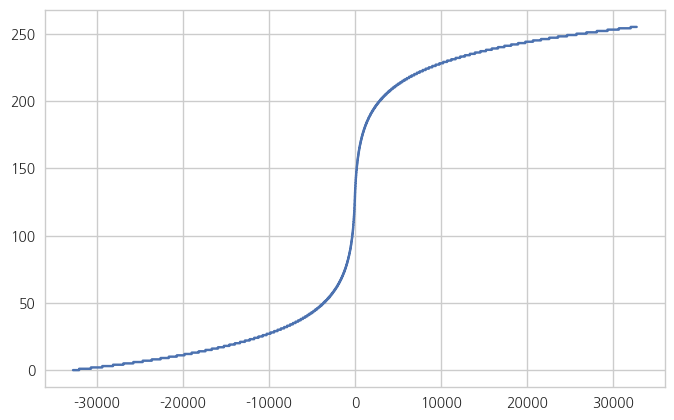

In [60]:
xx = np.arange(-32767, 32768)
yy = mu_encode(xx)

plt.plot(xx, yy)
plt.show()

In [61]:
df_data.sample(10)

,sound_id,0,1,2,3,4,5,6,7,8,...,87291,87292,87293,87294,87295,87296,87297,87298,87299,laugh
773,72568,0,0,0,0,0,0,0,0,0,...,63,60,-3,-12,22,12,-19,-22,-28,1.0
809,60799,0,0,0,0,0,-1,0,0,0,...,-69,20,121,40,-121,-123,26,182,184,1.0
1038,105424,0,0,0,0,0,0,0,0,0,...,0,-21,-33,2,-12,-9,14,-7,7,1.0
942,162769,1,0,0,0,0,0,0,0,-1,...,82,29,-2,27,7,-45,-31,15,33,1.0
517,377276,0,0,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.0
843,220670,0,0,0,0,0,0,0,0,0,...,221,116,72,97,82,61,60,11,-70,1.0
587,320472,0,0,-1,0,0,0,0,0,0,...,8,1,-3,-1,2,2,2,4,1,1.0
889,61064,0,0,0,0,0,0,0,0,0,...,7,18,32,53,62,65,62,42,22,1.0
559,41711,0,1,0,0,0,-1,0,0,0,...,31,45,80,104,44,1,18,36,84,1.0
240,190504,-1,0,0,0,0,0,0,0,0,...,46,46,47,41,27,16,6,4,8,0.0


In [84]:
df_data2 = df_data.copy()

In [76]:
df_data2['10000'].apply(mu_encode, inplace=True)

TypeError: mu_encode() got an unexpected keyword argument 'inplace'

In [86]:
%%time
df_data2 = df_data2.apply(mu_encode)

CPU times: user 1min 15s, sys: 645 ms, total: 1min 15s
Wall time: 1min 15s


In [94]:
df_data2.head(10)

,sound_id,0,1,2,3,4,5,6,7,8,...,87291,87292,87293,87294,87295,87296,87297,87298,87299,laugh
0,338346,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,125.0,124.0,124.0,124.0,124.0,125.0,124.0,125.0,126.0,0.0
1,246309,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,0.0
2,219433,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,128.0,128.0,128.0,128.0,127.0,127.0,127.0,127.0,127.0,0.0
3,211528,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,127.0,0.0
4,211529,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,125.0,123.0,124.0,124.0,125.0,126.0,123.0,122.0,122.0,0.0
5,391181,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,128.0,128.0,127.0,127.0,128.0,128.0,129.0,129.0,128.0,0.0
6,405204,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,127.0,...,126.0,124.0,125.0,129.0,129.0,130.0,131.0,129.0,127.0,0.0
7,259606,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,126.0,126.0,126.0,127.0,127.0,128.0,129.0,129.0,129.0,0.0
8,259608,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,138.0,127.0,118.0,119.0,129.0,136.0,137.0,136.0,131.0,0.0
9,346663,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,128.0,...,129.0,130.0,130.0,130.0,129.0,129.0,128.0,129.0,129.0,0.0


In [92]:
df_data2['sound_id'] = df_data['sound_id']

In [93]:
df_data2['laugh'] = df_data['laugh']

In [88]:
df_data.head(10)

,sound_id,0,1,2,3,4,5,6,7,8,...,87291,87292,87293,87294,87295,87296,87297,87298,87299,laugh
0,338346,0,0,0,0,0,0,0,0,0,...,-17,-18,-20,-22,-20,-17,-19,-17,-11,0.0
1,246309,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
2,219433,0,0,0,0,0,0,0,0,0,...,3,1,1,1,-2,-1,-3,-4,-4,0.0
3,211528,0,0,0,0,0,0,0,0,0,...,1,1,1,2,1,1,2,0,-1,0.0
4,211529,0,0,0,0,0,0,0,0,0,...,-12,-28,-22,-19,-14,-11,-25,-36,-38,0.0
5,391181,0,0,0,0,0,0,0,0,0,...,2,1,-3,-5,1,4,8,6,0,0.0
6,405204,0,0,0,0,0,0,0,0,-1,...,-7,-21,-16,7,11,16,23,8,-3,0.0
7,259606,0,0,0,1,0,0,0,0,0,...,-8,-7,-7,-4,-4,0,6,10,9,0.0
8,259608,0,0,0,0,0,0,0,0,0,...,75,-5,-67,-59,7,59,69,55,21,0.0
9,346663,0,0,0,0,0,0,1,0,0,...,11,13,13,12,9,6,5,6,6,0.0


In [95]:
df_data2.to_csv('../_data/combined_csv/180116_87300samp_cry386_laugh703_with_ids_mu_law.csv', index=False)

(array([   1.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,
           1.,    2.,    0.,    1.,    5.,    6.,    2.,    2.,   11.,
          12.,   11.,   19.,   34.,   38.,   53.,  101.,  397.,  167.,
          81.,   40.,   29.,   18.,   11.,   13.,   10.,    5.,    5.,
           5.,    2.,    2.,    1.,    0.,    0.,    0.,    0.,    1.,
           0.,    1.,    0.,    0.,    1.]),
 array([-16941.  , -16281.74, -15622.48, -14963.22, -14303.96, -13644.7 ,
        -12985.44, -12326.18, -11666.92, -11007.66, -10348.4 ,  -9689.14,
         -9029.88,  -8370.62,  -7711.36,  -7052.1 ,  -6392.84,  -5733.58,
         -5074.32,  -4415.06,  -3755.8 ,  -3096.54,  -2437.28,  -1778.02,
         -1118.76,   -459.5 ,    199.76,    859.02,   1518.28,   2177.54,
          2836.8 ,   3496.06,   4155.32,   4814.58,   5473.84,   6133.1 ,
          6792.36,   7451.62,   8110.88,   8770.14,   9429.4 ,  10088.66,
         10747.92,  11407.18,  12066.44,  12725.7 ,  13384.96,  14044.22,
        

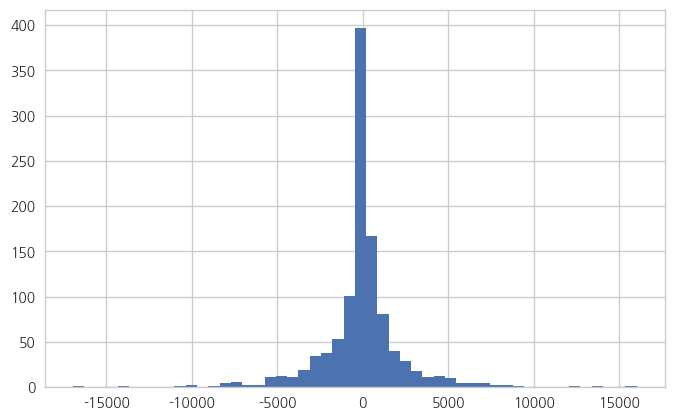

In [19]:
def mu_law_encode(audio, quantization_channels):
    '''Quantizes waveform amplitudes.'''
    with tf.name_scope('encode'):
        mu = tf.to_float(quantization_channels - 1)
        # Perform mu-law companding transformation (ITU-T, 1988).
        # Minimum operation is here to deal with rare large amplitudes caused
        # by resampling.
        safe_audio_abs = tf.minimum(tf.abs(audio), 1.0)
        magnitude = tf.log1p(mu * safe_audio_abs) / tf.log1p(mu)
        signal = tf.sign(audio) * magnitude
        # Quantize signal to the specified number of levels.
        return tf.to_int32((signal + 1) / 2 * mu + 0.5)